In [2]:
import midynet
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import fractions
import json
import pandas as pd

from pyhectiqlab import Run
from itertools import product
from matplotlib.lines import Line2D
from thresholds import *
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)
from midynet.statistics import Statistics
from midynet.utility import display
from itertools import product


run = Run("Duality with coupling figure", project="dynamica/midynet")

run.add_dataset_usage(
    "midynet1-duality-data", 
    version="1.0.1", 
)
run.add_artifact("approx-duality-coupling.ipynb")

display.setup_dir("./")


paths_to_figures = ["."]
paths_to_figures = list(map(pathlib.Path, paths_to_figures))
# path_to_data = pathlib.Path("../../../../data/midynet-data/figure4")
path_to_data = pathlib.Path("../../data/duality/approx-duality-coupling/")

def get_threshold(df, pname):
    gb = df.groupby(pname).mean()
    idx = gb["susceptibility"].argmax()
    return gb.iloc[idx].name

Attaching to an existing run (ID :32).


In [30]:
dynamics = ["glauber", "sis", "cowanfw", "cowanbw"]

recon = {}
pred = {}
thresholds = {}
x = {}

titles = {
    "glauber": r"Glauber", 
    "sis": r"SIS", 
    "cowanfw": r"Cowan",
    "cowanbw": r"Cowan"
}
gname = {
    "synthetic" : {
        "glauber": "geometric",
        "sis": "geometric",
        "cowanfw": "geometric",
        "cowanbw": "geometric",
    },
    "real" : {
        "glauber": "littlerock",
        "sis": "euairlines",
        "cowanfw": "celegans",
        "cowanbw": "celegans",
    },
}
xname = {
    "glauber": "coupling",
    "sis": "infection_prob",
    "cowanfw": "nu",
    "cowanbw": "nu",
}
xlabels = {
    "glauber": r"Coupling constant $J$", 
    "sis": r"Transmission rate $\lambda$", 
    "cowanfw": r"Potential gain $\nu$",
    "cowanbw": r"Potential gain $\nu$"
}

threshold_labels = {
    "glauber": r"$J_c$", 
    "sis": r"$\lambda_c$", 
    "cowanfw": r"$\nu_c^f$",
    "cowanbw": r"$\nu_c^b$"
}

for t, d in product(gname, dynamics):
    if t == "synthetic":
        filename = "reconinfo"
        path = path_to_data / f"{gname[t][d]}-{d}/{filename}.pkl"
    else:
        filename = "bayesian"
        path = path_to_data / f"{gname[t][d]}-{d.replace('fw', '_forward').replace('bw', '_backward')}/{filename}.pkl"
    df = next(iter(pd.read_pickle(path).values()))
    
    x[t, d] = df[f"data_model.{xname[d]}"]
    dup = x[t, d].duplicated(keep="first")
    recon[t, d] = Statistics.from_dataframe(df[~dup], "recon")
    pred[t, d] = Statistics.from_dataframe(df[~dup], "pred")
#     if "cowan" not in d:
#         recon[t, d].rescale_(1/32)
#         pred[t, d].rescale_(1/32)
    x[t, d] = df[~dup][f"data_model.{xname[d]}"]
    if d == "sis" and t == "synthetic":
        x[t, d] /= 0.5
    dname = d
    dname = dname.replace("fw", "_forward")
    dname = dname.replace("bw", "_backward")
    for t in ["synthetic", "real"]:
        if t == "synthetic":
            p = f"../../scripts/duality/data/thresholds/threshold-{dname}/susceptibility.pkl"
        else:
            p = f"../../scripts/duality/data/thresholds/threshold-rn-{dname}/susceptibility.pkl"
        df = next(iter(pd.read_pickle(p).values()))
        thresholds[t, d] = get_threshold(df, "data_model." + xname[d])
#         if not d.startswith("cowan"):
#         elif d.endswith("fw"):
#             std = df.groupby("data_model.nu").std()
#             idx = std["average"].argmax()
#             thresholds[t, d] = std.iloc[idx].name
#         else:
#             idx = df.diff()["average"].argmax() - 1
#             thresholds[t, d] = df["data_model.nu"][idx]
        
#     print(np.array(data["thresholds"])/5)

thresholds["synthetic", "cowanbw"] = 0.25
thresholds["synthetic", "cowanfw"] = 0.41

thresholds["real", "cowanbw"] = 0.06
thresholds["real", "cowanfw"] = 0.11



In [31]:
thresholds

{('synthetic', 'glauber'): 0.10789473684210527,
 ('real', 'glauber'): 0.02,
 ('synthetic', 'sis'): 0.05172413793103449,
 ('real', 'sis'): 0.010526315789473684,
 ('synthetic', 'cowanfw'): 0.41,
 ('real', 'cowanfw'): 0.11,
 ('synthetic', 'cowanbw'): 0.25,
 ('real', 'cowanbw'): 0.06}

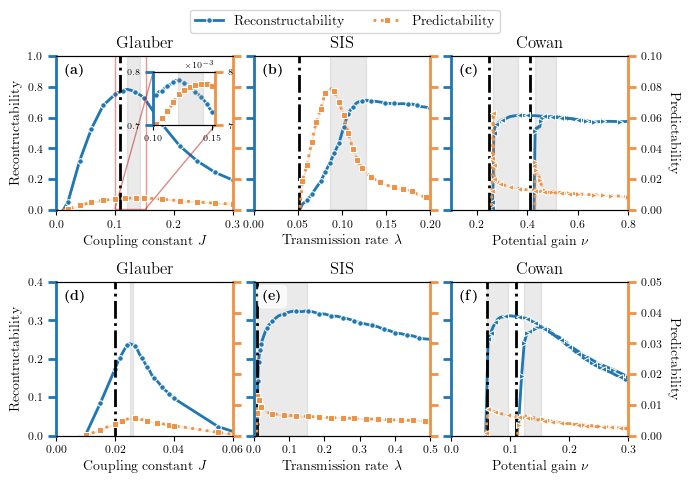

In [33]:
fig, ax = plt.subplots(2, 3, figsize=(7, 7 * 2./3), sharex=False, sharey=False)
axx = np.array([[_y.twinx() for _y in _x] for _x in ax])

rcolor = display.med_colors["blue"]
rlinestyle = "solid"

pcolor = display.med_colors["orange"]
plinestyle = "dotted"

interpolation = None

markevery = [1, 2, 2]
markesize = 4
linewidth = 2

handles = []

for i, d in enumerate(dynamics):
    rmarker = "o"
    pmarker = "s"
    
    if d == "cowanbw":
        i -= 1
        rmarker = pmarker = "<"
    elif d == "cowanfw":
        rmarker = pmarker = ">"
    
    # Synthetic graphs
    recon["synthetic", d].lineplot(
        x["synthetic", d],
        color=rcolor,
        marker=rmarker,
        linestyle=rlinestyle,
        linewidth=linewidth,
        markersize=markesize,
        interpolate=interpolation,
        ax=ax[0, i],
        markevery=0.05,
    )
    augx, augy = recon["synthetic", d].interpolate(x["synthetic", d], kind="cubic")
    max_recon = augx[np.argmax(augy.loc)]
    
    ax[0, i].set_ylim([0, 1])
    if d.startswith("cowan"):
        xmin, xmax = 0.1, 0.8
    else:
        xmin, xmax = x["synthetic", d].min(), x["synthetic", d].max()
    ax[0, i].set_xlim([xmin, xmax])
    ax[0, i].axvline(thresholds["synthetic", d], color="black", linestyle="-.", linewidth=2)
    if i == 0:
        ax[0, i].set_ylabel(r"Recontructability", fontsize=display.fontsizes["label"])
    else:
        ax[0, i].set_ylabel(None)
        ax[0, i].set_yticklabels([])
    ax[0, i].set_title(titles[d], fontsize=display.fontsizes["large_label"])
    ax[0, i].set_xlabel(xlabels[d], fontsize=display.fontsizes["label"])
    ax[0, i].tick_params(axis='both', labelsize=display.fontsizes["tick"])

    pred["synthetic", d].lineplot(
        x["synthetic", d],
        color=pcolor,
        marker= pmarker,
        linestyle=plinestyle,
        linewidth=linewidth,
        markersize=markesize,
        markevery=0.05,
        interpolate=interpolation,
        ax=axx[0, i],
    )
    augx, augy = pred["synthetic", d].interpolate(x["synthetic", d], kind="cubic")
    max_pred = augx[np.argmax(augy.loc)]
    axx[0, i].tick_params(axis='both', labelsize=display.fontsizes["tick"])
    axx[0, i].set_ylim([0, 0.1])
    if i == 2:
        axx[0, i].set_ylabel(
            r"Predictability", 
            fontsize=display.fontsizes["label"], 
            va="bottom", rotation=-90)
    else:
        axx[0, i].set_ylabel(None)
        axx[0, i].set_yticklabels([])
    max1, max2 = min(max_recon, max_pred), max(max_recon, max_pred)
    
    ax[0, i].axvspan(max1, max2, color=display.light_colors["grey"], alpha=0.2)
    
    ax[0, i].tick_params(axis='y', color=rcolor, length=6, width=2)
    axx[0, i].spines['left'].set_color(rcolor)
    axx[0, i].spines['left'].set_linewidth(2)
    axx[0, i].spines['right'].set_color(pcolor)
    axx[0, i].spines['right'].set_linewidth(2)
    axx[0, i].tick_params(axis='y', color=pcolor, length=6, width=2)
    if d != "cowanbw":
        display.Label.plot(ax[0, i], loc="top left")
    
    if d == "glauber":
        axins = ax[0, i].inset_axes([0.55, 0.55, 0.35, 0.35])
        xmin, xmax = 0.1, 0.16
        axxins = axins.twinx()
        idx = np.logical_and(x["synthetic", d]>xmin, x["synthetic", d]<xmax)
        recon["synthetic", d].lineplot(
            x["synthetic", d],
            indexes=idx,
            color=rcolor,
            marker=rmarker,
            linestyle=rlinestyle,
            linewidth=linewidth,
            markersize=markesize,
            markevery=2,
            interpolate=interpolation,
            ax=axins,
        )
        pred["synthetic", d].lineplot(
            x["synthetic", d],
            indexes=idx,
            color=pcolor,
            marker=pmarker,
            linestyle=plinestyle,
            linewidth=linewidth,
            markersize=markesize,
            markevery=2,
            interpolate=interpolation,
            ax=axxins,
        )
#         axins.axvline(thresholds["synthetic", d], color="black", linestyle="-.", linewidth=2)
        axxins.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
        axxins.axvspan(max1, max2, color=display.light_colors["grey"], alpha=0.2)

        axins.set_ylim([0.7, 0.8])
        axxins.set_ylim([0.007, 0.008])
        axins.set_yticks([0.7, 0.8])
        axxins.set_yticks([0.007, 0.008])
        
        axins.set_xlabel(None)
        axins.set_ylabel(None)
        axxins.set_ylabel(None)
        axins.tick_params(axis="both", labelsize=display.fontsizes["tiny"])
        axxins.tick_params(axis="both", labelsize=display.fontsizes["tiny"])
        axxins.yaxis.offsetText.set_fontsize(display.fontsizes["tiny"])
        
        axins.tick_params(axis='y', color=rcolor, length=6, width=2)
        axxins.spines['left'].set_color(rcolor)
        axxins.spines['left'].set_linewidth(2)
        axxins.spines['right'].set_color(pcolor)
        axxins.spines['right'].set_linewidth(2)
        axxins.tick_params(axis='y', color=pcolor, length=6, width=2)
        
        ax[0, i].indicate_inset_zoom(axxins, edgecolor=display.dark_colors["red"])
        ax[0, i].axvline(axins.get_xlim()[0], linestyle="-", 
                      color=display.med_colors["red"], 
                      alpha=0.5, linewidth=1)
        ax[0, i].axvline(axins.get_xlim()[1], linestyle="-", 
                      color=display.med_colors["red"], 
                      alpha=0.5, linewidth=1)
        
        
        handles.append(display.get_label_line("Reconstructability", style=axins.get_lines()[0]))
        handles.append(display.get_label_line("Predictability", style=axxins.get_lines()[0]))

for i, d in enumerate(dynamics):
    rmarker = "o"
    pmarker = "s"
    
    if d == "cowanbw":
        i -= 1
        rmarker = pmarker = "<"
    elif d == "cowanfw":
        rmarker = pmarker = ">"
    # Real-world graphs
    recon["real", d].lineplot(
        x["real", d],
        color=rcolor,
        marker=rmarker,
        linestyle=rlinestyle,
        linewidth=linewidth,
        markersize=markesize,
        interpolate=interpolation,
        ax=ax[1, i],
        markevery=0.05,
    )
    augx, augy = recon["real", d].interpolate(x["real", d], kind="cubic")
    max_recon = augx[np.argmax(augy.loc)]
    
    ax[1, i].set_ylim([0, 0.4])
    if d.startswith("cowan"):
        xmin, xmax = 0., 0.3
    else:
        xmin, xmax = x["real", d].min(), x["real", d].max()
#     ax[1, i].set_xlim([xmin, xmax])
    ax[1, i].axvline(thresholds["real", d], color="black", linestyle="-.", linewidth=2)
    if i == 0:
        ax[1, i].set_ylabel(r"Recontructability", fontsize=display.fontsizes["label"])
    else:
        ax[1, i].set_ylabel(None)
        ax[1, i].set_yticklabels([])
    ax[1, i].set_title(titles[d], fontsize=display.fontsizes["large_label"])
    ax[1, i].set_xlabel(xlabels[d], fontsize=display.fontsizes["label"])
    ax[1, i].tick_params(axis='both', labelsize=display.fontsizes["tick"])
#     ax[0, i].text(
#         thresholds["real", d] - 2 * (xmax - xmin) / 100, 
#         0.8, 
#         threshold_labels[d], 
#         fontsize=8, 
#         rotation=90, 
#         horizontalalignment="right",
#         va="bottom"
#     )

    pred["real", d].lineplot(
        x["real", d],
        color=pcolor,
        marker=pmarker,
        linestyle=plinestyle,
        linewidth=linewidth,
        markersize=markesize,
        markevery=0.05,
        interpolate=interpolation,
        ax=axx[1, i],
    )
    augx, augy = pred["real", d].interpolate(x["real", d], kind="cubic")
    max_pred = augx[np.argmax(augy.loc)]
    axx[1, i].tick_params(axis='both', labelsize=display.fontsizes["tick"])
    axx[1, i].set_ylim([0, 0.05])
#     axx[1, i].set_yticks([0, 0.005, 0.01, 0.015,0.02])
    if i == 2:
        axx[1, i].set_ylabel(
            r"Predictability", 
            fontsize=display.fontsizes["label"], 
            va="bottom", rotation=-90)
    else:
        axx[1, i].set_ylabel(None)
        axx[1, i].set_yticklabels([])
    max1, max2 = min(max_recon, max_pred), max(max_recon, max_pred)
    
    ax[1, i].axvspan(max1, max2, color=display.light_colors["grey"], alpha=0.2)
    
    ax[1, i].tick_params(axis='y', color=rcolor, length=6, width=2)
    axx[1, i].spines['left'].set_color(rcolor)
    axx[1, i].spines['left'].set_linewidth(2)
    axx[1, i].spines['right'].set_color(pcolor)
    axx[1, i].spines['right'].set_linewidth(2)
    axx[1, i].tick_params(axis='y', color=pcolor, length=6, width=2)
    if d != "cowanbw":
        display.Label.plot(ax[1, i], loc="top left")
        
ax[1, 0].set_xlim([0, 0.06])
ax[1, 1].set_xlim([0, 0.5])
ax[1, 2].set_xlim([0, 0.3])

display.Label.clear()
        
lg = fig.legend(
    handles=handles, 
    loc="center",
    fontsize=10, 
    ncol=2, 
    bbox_to_anchor=(0.5, 1.0)
)
fig.tight_layout(w_pad=0.15)

for p, fmt in product(paths_to_figures, ["png", "pdf", "svg"]):
    fig.savefig(p / fmt / f"approx-duality-coupling.{fmt}", bbox_extra_artists=(lg,), bbox_inches='tight')
run.add_figure(fig, "approx-duality-coupling")

In [23]:
import graphinf, tqdm.notebook as tqdm, seaborn as sns

from math import ceil
from collections import defaultdict

def degrees(g):
    adj = np.array(g.get_adjacency_matrix(True))
    return adj.sum(0)

In [27]:
g0 = graphinf.utility.load_graph("../../data/graphs/celegans.pkl")

G = graphinf.graph.ConfigurationModel(g0)
x = np.linspace(0.04, 0.2, 20)

data = defaultdict(list)
for _x in tqdm.tqdm(x):
    X = graphinf.data.dynamics.CowanDynamics(G, length=1000, nu=_x, a=8., eta=0.1)
    for _ in range(10):
        X.sample(ceil(0.01 * g0.get_size()))
        data["x"].append(_x)
        data["avg_fw"].append(np.mean(X.get_past_states()))
        X.sample(g0.get_size())
        data["avg_bw"].append(np.mean(X.get_past_states()))
        



  0%|          | 0/20 [00:00<?, ?it/s]

<Axes: xlabel='x', ylabel='avg_fw'>

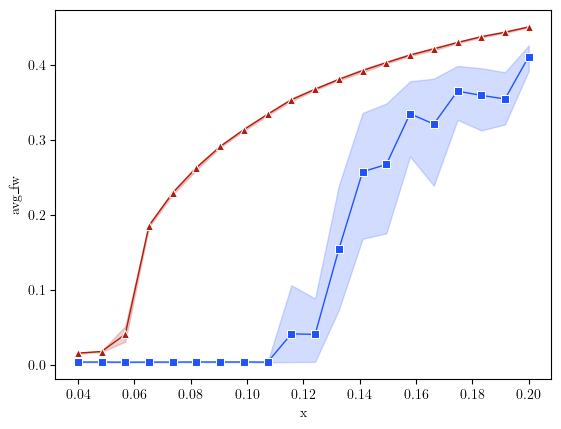

In [28]:
sns.lineplot(data, x="x", y="avg_fw")
sns.lineplot(data, x="x", y="avg_bw")

In [6]:
graphs = {
    "littlerock": graphinf.utility.load_graph("../../data/graphs/littlerock.pkl"),
    "euairlines": graphinf.utility.load_graph("../../data/graphs/euairlines.pkl"),
    "celegans": graphinf.utility.load_graph("../../data/graphs/celegans.pkl"),
}

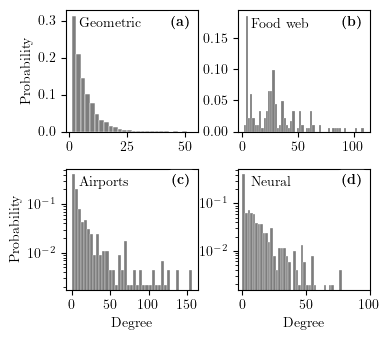

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(8/2, 7/2))
ax = ax.flatten()
display.Label.clear()
binwidth = {
    0:2, 1:2, 2:4, 3:2
}
for i, g in enumerate([None] + list(graphs.values())):
    if g is None:
        degs = np.random.geometric(1./6, size=10000)
    else:
        degs = degrees(g)
    
    sns.histplot(
        degs, 
#         discrete=True,
        binwidth=binwidth[i],
        ax=ax[i], 
        color=display.med_colors["grey"],
        edgecolor="w",
        stat="probability",
    )
    if i in [2, 3]:
        ax[i].set_xlabel("Degree")
    else:
        ax[i].set_xlabel(None)
    if i in [0, 2]:
        ax[i].set_ylabel("Probability")
    else:
        ax[i].set_ylabel(None)
    if i in [2, 3]:
        ax[i].set_yscale("log")
    display.Label.plot(ax[i], loc="top right")

ax[0].set_xticks([0, 25, 50])
ax[1].set_xticks([0, 50, 100])
ax[2].set_xticks([0, 50, 100, 150])
ax[3].set_xticks([0, 50, 100])

ax[0].text(0.1, 0.85, "Geometric",  fontsize=display.fontsizes["label"], transform=ax[0].transAxes)
ax[1].text(0.1, 0.85, "Food web",  fontsize=display.fontsizes["label"], transform=ax[1].transAxes)
ax[2].text(0.1, 0.85, "Airports",  fontsize=display.fontsizes["label"], transform=ax[2].transAxes)
ax[3].text(0.1, 0.85, "Neural",  fontsize=display.fontsizes["label"], transform=ax[3].transAxes)
fig.tight_layout(w_pad=0.15)
for p, fmt in product(paths_to_figures, ["png", "pdf", "svg"]):
    fig.savefig(p / fmt / f"degree-distribution.{fmt}")